In [1]:
# Loading packages
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import mne
import mne_nirs
import pandas as pd

from scipy import stats
from scipy.stats import sem
from mne.preprocessing.nirs import (optical_density,
                                    temporal_derivative_distribution_repair)
from itertools import compress
from mne_nirs.channels import (get_long_channels,
                               get_short_channels,
                               picks_pair_to_idx)
from mne.viz import plot_compare_evokeds
from pprint import pprint


#from fooof import FOOOF
from mne_nirs.preprocessing import quantify_mayer_fooof

# Import StatsModels
import statsmodels.formula.api as smf
from mne_nirs.statistics import statsmodels_to_results
# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from itertools import compress
from collections import defaultdict
from copy import deepcopy
from pprint import pprint

from mne_nirs.experimental_design import make_first_level_design_matrix, create_boxcar
from mne_nirs.statistics import run_glm

from nilearn.plotting import plot_design_matrix
from mne_nirs.utils._io import glm_to_tidy

from mne_nirs.statistics import run_GLM, glm_region_of_interest
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed
from mne_nirs.visualisation import plot_timechannel_quality_metric

import pickle

import sys

# stimrenaming = {'1.0': 'Stimulus', '2.0':'Stimulus', '3.0':'No Stimulus', '4.0':'Stimulus', '5.0': 'Stimulus','6.0': 'Stimulus', '7.0': 'Stimulus', '8.0': 'No Stimulus'}
# T_Noi_rename = {'9.0': 'Stimulus'}

stimrenaming = {'1.0': 'Speech_Sil', '2.0':'Noise_Sil', '3.0':'Control_Sil', '4.0':'A_SPIN_Sil', '5.0': 'Delete','6.0': 'Delete', '7.0': 'Speech_Noi', '8.0': 'Control_Noi'}
T_Noi_rename = {'9.0': 'T_Noi'}

plots = False
glm = True
waveform = True

epochrejectCutOffs =[]
df_channelstats = pd.DataFrame() 
df_roiglm = pd.DataFrame() 
df_shortchanglm = pd.DataFrame() 
all_evokeds_allCond = defaultdict(list)
all_evokeds_TempRoi = defaultdict(list) # all cond but only temp channels epoched
all_evokeds_ShortChans = defaultdict(list)

nr_of_bad_epochs = []
bad_channels =[]
percent_bad_epochs = []

subjfolder = r"\Subject01\2023-04-18_002"

In [ ]:
#%% preprocessing

#set rejection parameters 
Nstdtoforpeaktopeakreject = 9 # only for short chans?
fixed_cutoff = dict(hbo=45e-6)
sci_cutoff = 0.7
cv_cutoff= 0.2

#1. load data ###############################################################
root = r"C:\Users\bede\OneDrive - Danmarks Tekniske Universitet\fNIRS - PhD Project\Data\Alina's study\study data"
raw = mne.io.read_raw_nirx(root+subjfolder, verbose=True, preload=True)
#raw = raw.resample(1) # resampling acts like a low-pass filter. good to reduce autocorrelations, and speed up processing time, risk of loosing data, too much smoothing, aliasing
        #huppert:loss of stats power, he uses normally 5 Hz

# 2. delete exp start ######################################################
annotations = raw.annotations
eventlist = annotations.description
raw.annotations.delete(np.where(eventlist =='11.0')) # exp start

#3. set stimulus duration for boxcar funct###################################
#stimdur = raw.info['sfreq']  # 3.4# try shorter boxcar original stim dur 5.7
stimdur = 5.7
raw.annotations.set_durations(stimdur)   

#4.  rename events based on given input #####################################
raw.annotations.rename(stimrenaming)
    
#5. trim baseline ##########################################################
first_event_time = raw.annotations.onset[0]  # Time of the first event
last_event_time = raw.annotations.onset[-1]  # Time of the last event
# Define pre and post baseline durations
pre_baseline = 10  # 10 seconds before the first event
post_baseline = 18  # 18 seconds after the last event
# Calculate the start and end times for cropping
start_time = max(first_event_time - pre_baseline, 0)  # Ensure start_time is not negative
end_time = min(last_event_time + post_baseline, raw.times[-1])  # Ensure end_time does not exceed the recording
# # Crop the raw object
# raw = raw.copy().crop(tmin=start_time, tmax=end_time)


# [6. delete channels with unreasonable distance (that were accidently in montage for this data set)]
dists = mne.preprocessing.nirs.source_detector_distances(raw.info)
ch_names_all = raw.ch_names 
ch_names_keep = np.array(ch_names_all)[(dists > 0.021) | (dists < 0.01)].tolist() # should be 114, includes 16 short chans (hbo + hbr), 98 long chans
raw = raw.copy().pick(ch_names_keep) 
    
#7. no resampling # the higher the better (but not real improvement for sampling rates > 0.6)  (luke et al.2021)

#8. converson to OD  ##########################################################
raw_od = mne.preprocessing.nirs.optical_density(raw)



Loading C:\Users\bede\OneDrive - Danmarks Tekniske Universitet\fNIRS - PhD Project\Data\Alina's study\study data\Subject01\2023-04-18_002
Reading 0 ... 15741  =      0.000 ...  4029.696 secs...


In [6]:
raw_od.plot(
    n_channels=len(raw_od.ch_names), duration=4000
)

Using qt as 2D backend.


In [ ]:
len(raw_od.ch_names)


114

In [4]:
N = len(raw_od.times)
print(N)
T = raw_od.times[-1]
fs = N/T
print(fs)
print(raw_od.info["sfreq"])

15742
3.906498157677403
3.90625


Used Annotations descriptions: [np.str_('A_SPIN_Sil'), np.str_('Control_Noi'), np.str_('Control_Sil'), np.str_('Delete'), np.str_('Noise_Sil'), np.str_('Speech_Noi'), np.str_('Speech_Sil')]


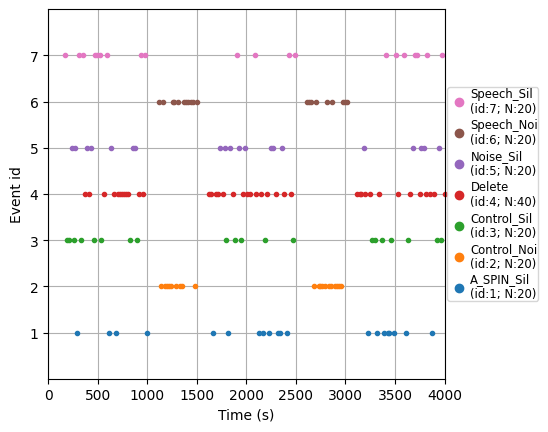

In [7]:
events, event_dict = mne.events_from_annotations(raw_od)
mne.viz.plot_events(events=events,event_id=event_dict,sfreq=raw_od.info["sfreq"])
events_times = events[:,0]/raw_od.info['sfreq'] - start_time

Used Annotations descriptions: [np.str_('A_SPIN_Sil'), np.str_('Control_Noi'), np.str_('Control_Sil'), np.str_('Delete'), np.str_('Noise_Sil'), np.str_('Speech_Noi'), np.str_('Speech_Sil')]


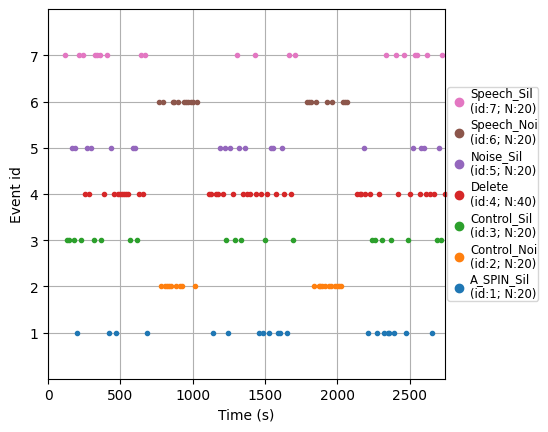

Total blocks identified: 8


In [ ]:

events = events[np.argsort(events[:, 0])]

cropped_blocks = []
gap_threshold = 30  # seconds
post_stimulus_buffer = 15  # seconds to include after the last stimulus in a block
pre_stimulus_buffer = 5 # seconds to exclude before the start of the next block

start_idx = 0
while start_idx < len(events):
    # Start of the block is at the onset of the current event
    block_start = events[start_idx, 0] / raw_od.info['sfreq'] - pre_stimulus_buffer
    
    # Find the end of the block
    end_idx = start_idx + 1
    while end_idx < len(events) and (events[end_idx, 0] - events[end_idx - 1, 0]) / raw_od.info['sfreq'] < gap_threshold:
        end_idx += 1

    # End of the block is determined by the last event plus a buffer
    block_end = events[end_idx - 1, 0] / raw_od.info['sfreq'] + post_stimulus_buffer

    # Ensure block_end does not exceed the maximum time in the raw data
    block_end = min(block_end, raw_od.times[-1])

    if block_start < block_end:
        # Crop the data
        cropped_block = raw_od.copy().crop(tmin=block_start, tmax=block_end)
        cropped_blocks.append(cropped_block)
    else:
        print(f"Skipping block due to invalid time range: tmin={block_start}, tmax={block_end}")

    # Move to the next set of events
    start_idx = end_idx

print(f"Total blocks identified: {len(cropped_blocks)}")

# Concatenate the cropped blocks
concatenated_raw = mne.concatenate_raws(cropped_blocks)


    

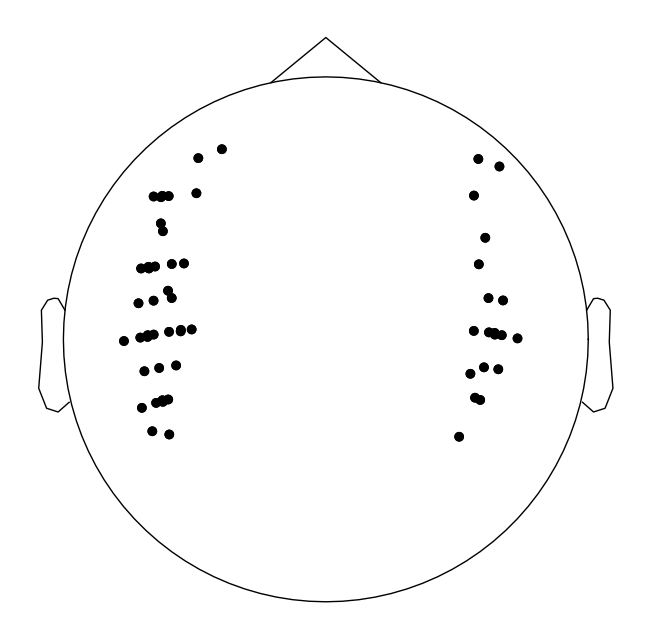

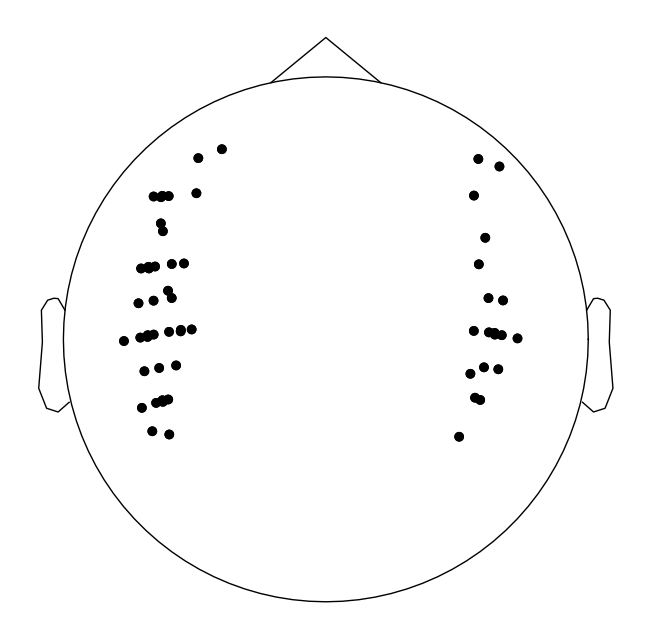

In [ ]:
raw_od.plot_sensors()

In [ ]:


# Now you can compute the SCI on the concatenated data
sci = mne.preprocessing.nirs.scalp_coupling_index(concatenated_raw)
# fig, ax = plt.subplots()
# ax.hist(sci)
# ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
# plt.show()

# Identify bad channels based on SCI for the concatenated data
bads_SCI = list(compress(concatenated_raw.ch_names, sci <sci_cutoff)) # 0.8 recommended, 0.89 knee point indata without already rejected subjects
print(bads_SCI)
print("Channels with SCI < {sci_cutoff}:", bads_SCI)

# check peak power
concatenated_raw, PPscores, times = peak_power(concatenated_raw, time_window=10)  # 60 s windows 
# plot_timechannel_quality_metric(concatenated_raw, scores, times, threshold=0.1,
#                             title="Peak Power Quality Evaluation")
howmanybadPP = np.sum(PPscores < 0.1,axis = 1)
howmanybadPP_percent = howmanybadPP/PPscores.shape[1]
#bads_PP = list(compress(concatenated_raw.ch_names, np.mean(PPscores,1) < 0.1)) # does not make much sense to average, better have a count.. mor ethan 50% of windows under 0.1
bads_PP = [name for name, percent in zip(concatenated_raw.ch_names, howmanybadPP_percent) if percent > 0.5]
print(bads_PP)

print("Channels with > 50% 10s windows with Peak power < 0.1:", bads_PP)

ChanStd = np.std(concatenated_raw._data, axis=1)
bads_CV = list(compress(concatenated_raw.ch_names, ChanStd > cv_cutoff))  # knee point 

bads_CV_full = set()
for chan in bads_CV:
    import re
    base_name = re.sub(r'\s+\d+$', '', chan)  # Remove the wavelength part
    # Add both wavelength versions to the set
    bads_CV_full.add(f"{base_name} 760")
    bads_CV_full.add(f"{base_name} 850")

# Now update bads_CV to include pairs
bads_CV = list(bads_CV_full)

print("Channels with CV > {cv_cutoff}:", bads_CV)
bads_PP_set = set(bads_PP)
bads_SCI_set = set(bads_SCI)
#inSCIbutnotPP= bads_SCI_set.difference(bads_PP_set)
# inPPbutnotSCI = bads_PP_set.difference(bads_SCI_set)
# print("Channels detected as bad by SCI but not by PeakPower :", inSCIbutnotPP)
# print("Channels as bad by PeakPower but not by SCI:", inPPbutnotSCI)

bads_SCI_PP_set = bads_SCI_set.union(bads_PP_set)

# add also channels found by CV to set
bads_CV_set = set(bads_CV)
bads_SCI_PP_CV_set = bads_SCI_PP_set.union(bads_CV_set)
bads_SCI_PP_CV = list(bads_SCI_PP_CV_set)

# output_file_path = r'C:\Users\AICU\OneDrive - Demant\Documents - Eriksholm Research Centre\Research Projects\AudTacLoc\fNIRS results - reanalysis with more subjects\Final files_21_03_24\newMNEbadchanreject\separateConditions_MAINANALYSIS/infoBadChansSubj_'+ str(ID) +'.txt'

# # Open the file in write mode ('w')
# with open(output_file_path, 'w') as file:
#     # Write the information to the file
#     # file.write(f"Channels detected as bad by SCI but not by PeakPower: {inSCIbutnotPP}\n")
#     # file.write(f"Channels as bad by PeakPower but not by SCI: {inPPbutnotSCI}\n")
#     file.write(f"Data was cut into {len(cropped_blocks)} blocks and reconcatenated to base bad chan rejection on segments with stimulus events only")
#     file.write(f"Bad channels as detected by SCI: {bads_SCI}\n")
#     file.write(f"Bad channels as detected by peak power: {bads_PP}\n")
#     file.write(f"Bad channels as detected by CV: {bads_CV}\n")
#     file.write(f" Union of all-->Bad channels excluded for further analyses: {bads_SCI_PP_CV}\n")

# use mne diff for rejection
raw_od.info['bads']= bads_SCI_PP_CV

#if plots:
    # concatenated_raw.plot(n_channels=len(concatenated_raw.ch_names),
    #         duration=500, show_scrollbars=False)
    # events, event_dict = mne.events_from_annotations(concatenated_raw)
    # fig = mne.viz.plot_events(events, event_id=event_dict,
    #                   sfreq=raw.info['sfreq'])
    
    # raw_od.plot(n_channels=len(raw_od.ch_names),
    #         duration=500, show_scrollbars=False)

#############################repeat SCI on long chan only to add this info to plot later:

ODcopy = get_long_channels(concatenated_raw.copy())
sci_longchans = mne.preprocessing.nirs.scalp_coupling_index(ODcopy)
sci_longchans = sci_longchans[::2] #keep one val per channel only
# lsits should match chnames of ODcopy hbo only
    # same for CV 
CV_longchans = np.std(ODcopy._data, axis=1) 
CV_longchans = CV_longchans[::2] #keep the hbo value only    
    # and pp
ODcopy, PPscores_longch, times = peak_power(ODcopy, time_window=10)  # 60 s windows 
# plot_timechannel_quality_metric(concatenated_raw, scores, times, threshold=0.1,
#                             title="Peak Power Quality Evaluation")
howmanybadPP_longch = np.sum(PPscores_longch < 0.1,axis = 1)
howmanybadPP_percent_longch = howmanybadPP_longch/PPscores_longch.shape[1]
howmanybadPP_percent_longch = howmanybadPP_longch[::2]
            

# ###### check SQI for comparison
# # needs OD and HB signals of one channel
# #loop over data, extract the four parameters and call SQI for that channel
# fs = raw_od.info['sfreq']  # Sampling frequency

# # Convert optical density to haemoglobin concentration
# raw_haemo_copy = mne.preprocessing.nirs.beer_lambert_law(raw_od.copy(), ppf=0.1)

# # Example processing loop through channels
# # SQIs = []
# # for i in range(0, raw_od._data.shape[0], 2):  # Assuming channels are paired: WL1, WL2
# #     od1 = raw_od._data[:, i]   # Wavelength 1
# #     od2 = raw_od._data[:, i+1] # Wavelength 2
    
# #     hbo = raw_haemo_copy._data[:, i]   # Corresponding HbO
# #     hbr = raw_haemo_copy._data[:, i+1] # Corresponding HbR
    
# #     # Call SQI or any other quality metric function
# #     SQIvalue = SQI(od2, od1, hbo, hbr, fs)
# #     SQIs.append(SQIvalue)
    


# Continue with your existing code for SCI and peak power analysis...

corrected_tddr = temporal_derivative_distribution_repair(raw_od)

#HB
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(corrected_tddr, ppf = 0.1); # default option, same as in nirstoolbox (it comes from dpf =6/ partial volume correctioin = 60), however ppf = 6 is still recommended  in nirstoolbox PPF = 5 / 50;   % partial pathlength factor 


raw_haemo_longandshort = raw_haemo.copy() 

#Filtering
raw_haemo = raw_haemo.filter(l_freq = None, h_freq = 0.25,  
                                method="iir", iir_params =dict(order=5, ftype='butter'))
    #high-pass
raw_haemo= raw_haemo.filter(l_freq =  0.005, h_freq = None, method="iir", iir_params =dict(order=5, ftype='butter'))#t0.05 was cutoff in andreas analysis
    


if ID >18:
        raw_haemo.annotations.rename(T_Noi_rename)

annotations = raw_haemo.annotations
eventlist = annotations.description
raw_haemo.annotations.delete(np.where(eventlist =='Delete')) # exp start # delete conditions of no interest -> helps epoch cleaning